In [2]:
library(qiime2R)
library(tidyr)
library(tibble)
library(ggplot2)
library(vegan)
library(microbiome)
library(phyloseq)
library("tidyverse")
library("dplyr")

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7

Loading required package: phyloseq


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2020 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:vegan’:

    diversity


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform


── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ readr   2.1.2     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.1
✔ dplyr   1.0.9     

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ microbiome::alpha() masks ggplot2::alpha()
✖ dplyr::filter()     masks 

In [3]:
# Read in the 16S qza files and clean them up for phyloseq
ASVs <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/table-BacArc_resistada.qza")
ASVs <- ASVs$data # Extract the count data from list

tree_file <-read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/rooted-BacArc_resistada.qza")$data


taxa_16S <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/taxonomy_resistada.qza")
taxa_16S <- taxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>% 
# Convert taxonomy info to data frame with correct taxonomy labels
#taxa <- taxa_16S[-1,]
select(-Confidence) %>% arrange(Feature.ID) %>% mutate(ASV = 1:n()) %>% 
mutate(newcol = "ASV") %>%
unite("ASVs", newcol:ASV) %>%
filter(Phylum !=" p__Chlorophyta") %>%
filter(Phylum !="NA")


Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 5374 rows [3, 6, 9, 11, 12, 14, 15, 16, 17, 18, 22, 23, 27, 31, 36, 38, 42, 45, 49, 51, ...].”


In [4]:
meta = read.csv("/Users/stephanie.rosales/Documents/omics_projects/Resitada/metadata_RESISTADA.csv", 
                header = T, row.names = 1,
na.strings = c("", "NA")) 

In [5]:
#meta = meta %>% 
#mutate_all(funs(str_replace_all(.,"Placebo", "P"))) %>% 
#mutate_all(funs(str_replace_all(.,"Pathogen", "D"))) %>% 
#mutate_all(funs(str_replace_all(.,"Ambient_Homogenate DL", "Ambient +\n Homogenate DL"))) %>% 
#mutate_all(funs(str_replace_all(.,"Ambient_Homogenate AH", "Ambient +\n Homogenate AH"))) #%>% 
#mutate_all(funs(str_replace_all(.,"NH4", "Elevated NH4"))) 

In [6]:
ps_pre= phyloseq(otu_table(ASVs, taxa_are_rows= T),
tax_table(as.data.frame(taxa_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(meta), tree_file)
ps_pre

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 280 samples ]
sample_data() Sample Data:       [ 280 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [7]:
dups = c("N169_256_R2", "N157_265_R2", "N165_296_R2", "N161_A067_R2", "N185_A088_R2",
                                 "N164_A089_R2","N119_A107","N267_A110","N7_A114", "N156_A115","N158_A116",
                                 "N101_A118","N160_A119","N277_A125")

ps = subset_samples(ps_pre, !ID %in% dups & Genotype!=c("U41"))
                                                    #,"U44")) 
ps


ps=subset_taxa(ps, Phylum!="NA")
ps


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 257 samples ]
sample_data() Sample Data:       [ 257 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 257 samples ]
sample_data() Sample Data:       [ 257 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [8]:
ps_homgenate=subset_samples(ps_pre, Type=="Homogenate")
ps_homgenate

ps_razor =subset_samples(ps, Type=="Razor")
ps_razor

ps_razor_nr =subset_taxa(ps_razor, Genus!=" g__MD3-55" )
ps_razor_nr

ps_Clipped =subset_samples(ps, Type=="Clipped")
ps_Clipped


ps_clip_nr =subset_taxa(ps_Clipped, Genus!=" g__MD3-55" )
ps_clip_nr

ps_neg =subset_samples(ps, Type=="Neg")
ps_neg


ps_paired = subset_samples(ps_Clipped, Pairs=="paired")
ps_paired

ps_unpaired =subset_samples(ps_Clipped, Pairs=="unpaired")
ps_unpaired


#ps_unpaired =subset_samples(ps_Clipped, Pairs=="unpaired")
#ps_unpaired

ps_Am_Pl =subset_samples(ps, Combo=="Ambient_Placebo")
ps_Am_Pl

ps_Am_Pl_c =subset_samples(ps_Clipped, Combo=="Ambient_Placebo")
ps_Am_Pl_c

ps_Am_Pl_r =subset_samples(ps_razor, Combo=="Ambient_Placebo")
ps_Am_Pl_r


ps_Am_Pa_c =subset_samples(ps_Clipped, Combo=="Ambient_Pathogen")
ps_Am_Pa_c


#ps_placebo =subset_samples(ps_paired, Diseased=="Homogenate AH")
#ps_placebo

#ps_pathogen =subset_samples(ps_paired, Diseased=="Homogenate DL")
#ps_pathogen

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 7 samples ]
sample_data() Sample Data:       [ 7 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 60 samples ]
sample_data() Sample Data:       [ 60 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7625 taxa and 60 samples ]
sample_data() Sample Data:       [ 60 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 7625 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7625 tips and 6730 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7625 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 7625 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7625 tips and 6730 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 5 samples ]
sample_data() Sample Data:       [ 5 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 135 samples ]
sample_data() Sample Data:       [ 135 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 56 samples ]
sample_data() Sample Data:       [ 56 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 62 samples ]
sample_data() Sample Data:       [ 62 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 42 samples ]
sample_data() Sample Data:       [ 42 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 20 samples ]
sample_data() Sample Data:       [ 20 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [9]:
ps_fill_razor = filter_taxa(ps_razor, function(x) sum(x > 10) > (0.10*length(x)), TRUE)
ps_fill_razor 
                            
ps_fill_razor_nr = filter_taxa(ps_razor_nr, function(x) sum(x > 5) > (0.10*length(x)), TRUE)
ps_fill_razor_nr                          

ps_fill_clip = filter_taxa(ps_Clipped, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_clip
                           
ps_fill_clip_nr = filter_taxa(ps_clip_nr, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_clip_nr                           

ps_fill_neg = filter_taxa(ps_neg, function(x) sum(x > 0) > (0.00*length(x)), TRUE)
ps_fill_neg                         
   
                                                      
ps_fill_pair = filter_taxa(ps_paired, function(x) sum(x > 5) > (0.15*length(x)), TRUE)
ps_fill_pair  
                           
                                       
ps_Am_Pa_c_fill = filter_taxa(ps_Am_Pa_c, function(x) sum(x > 0) > (0.00*length(x)), TRUE)
ps_Am_Pa_c_fill                          

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 32 taxa and 60 samples ]
sample_data() Sample Data:       [ 60 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 32 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 32 tips and 26 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19 taxa and 60 samples ]
sample_data() Sample Data:       [ 60 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 19 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19 tips and 15 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 94 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 94 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 94 tips and 75 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 66 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 66 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 66 tips and 52 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 212 taxa and 5 samples ]
sample_data() Sample Data:       [ 5 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 212 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 212 tips and 199 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 72 taxa and 135 samples ]
sample_data() Sample Data:       [ 135 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 72 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 72 tips and 55 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2017 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 2017 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2017 tips and 1837 internal nodes ]

In [10]:
ps_clr_razor <- microbiome::transform(ps_fill_razor, 'clr')
psr_clr.ord_razor <- ordinate(ps_clr_razor, "RDA", "euclidean")

ps_clr_razor_nr <- microbiome::transform(ps_fill_razor_nr, 'clr')
psr_clr.ord_razor_nr <- ordinate(ps_clr_razor_nr, "RDA", "euclidean")



ps_clr_clip <- microbiome::transform(ps_fill_clip, 'clr')
psr_clr.ord_clip <- ordinate(ps_clr_clip, "RDA", "euclidean")


ps_clr_fill_pair <- microbiome::transform(ps_fill_pair, 'clr')
ps_clr.ord_fill_pair <- ordinate(ps_clr_fill_pair, "RDA", "euclidean")

#ps_clr_fill_unpair <- microbiome::transform(ps_fill_unpair, 'clr')
#ps_clr.ord_fill_unpair <- ordinate(ps_clr_fill_unpair, "RDA", "euclidean")


#ps_clr_Am_Pl_c  <- microbiome::transform(ps_fill_Am_Pl_c, 'clr')                           
#ps_clr.ord_Am_Pl_c  <- ordinate(ps_clr_Am_Pl_c, "RDA", "euclidean")
                               
#ps_clr_Am_Pl_r  <- microbiome::transform(ps_fill_Am_Pl_r, 'clr')                           
#ps_clr.ord_Am_Pl_r  <- ordinate(ps_clr_Am_Pl_r, "RDA", "euclidean")


#ps_clr_Pl_c  <- microbiome::transform(ps_placebo_fill, 'clr')                           
#ps_clr.ord_Pl_c  <- ordinate(ps_placebo_fill, "RDA", "euclidean")


#ps_clr_Pa_c  <- microbiome::transform(ps_pathogen_fill, 'clr')                           
#ps_clr.ord_Pa_c  <- ordinate(ps_pathogen_fill, "RDA", "euclidean")

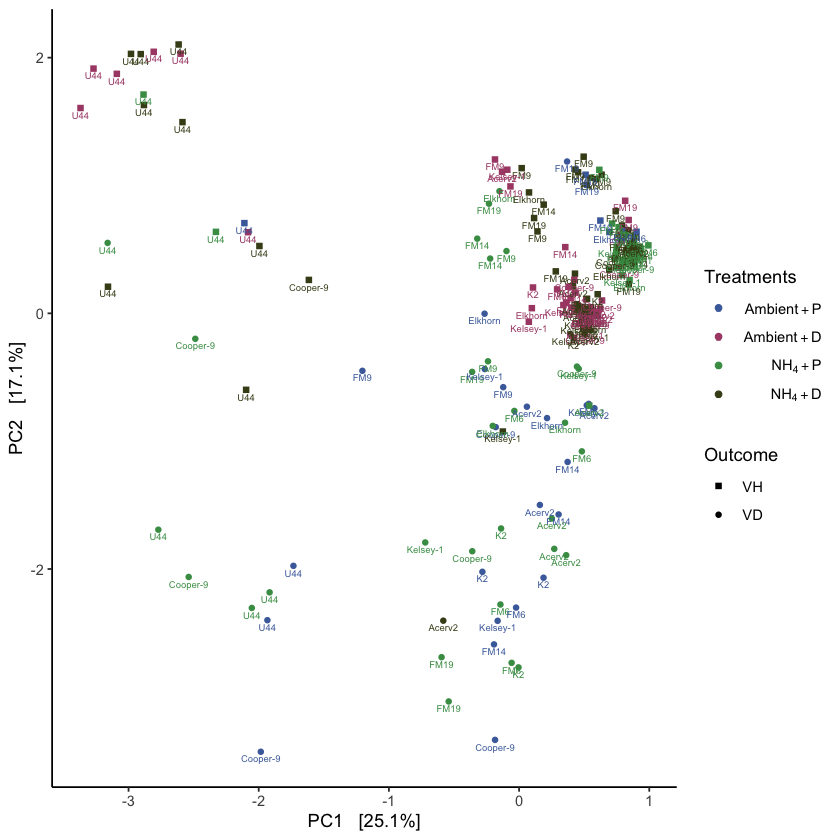

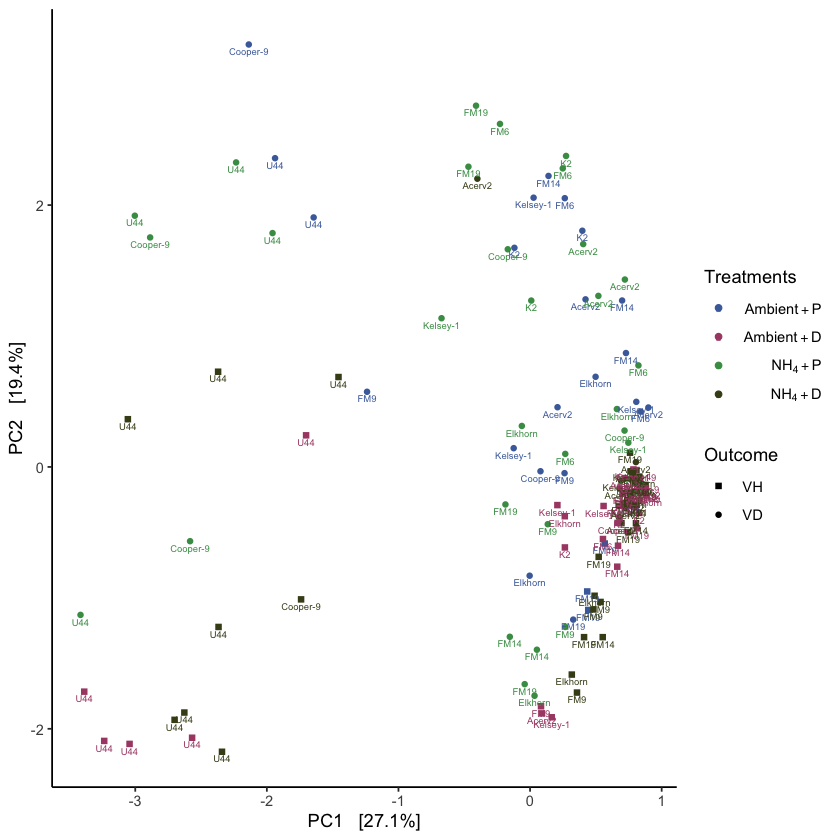

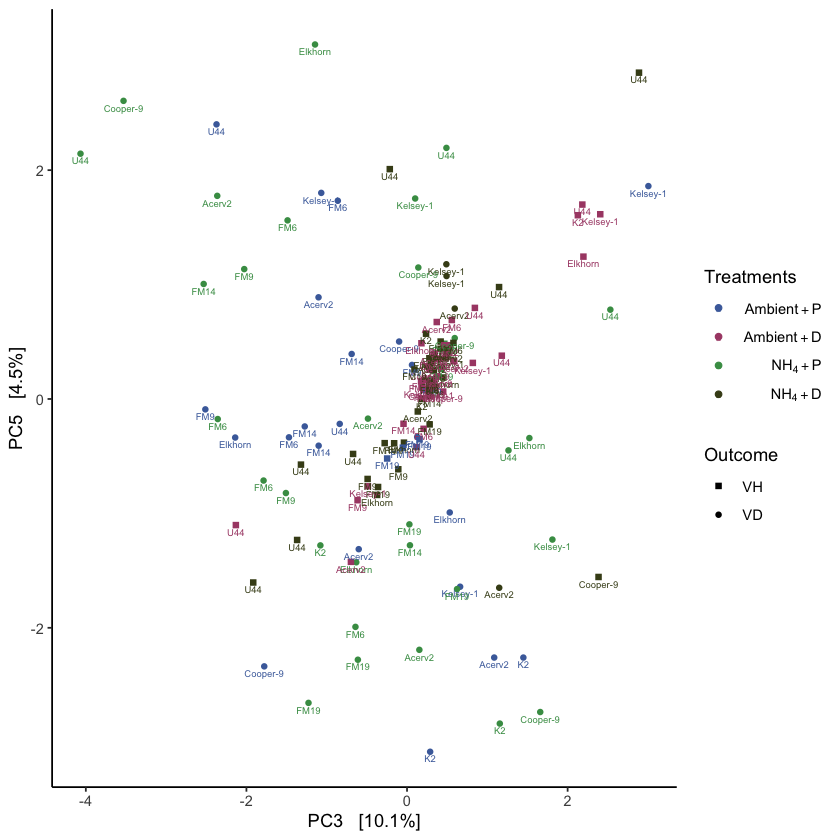

In [11]:


lab1 <- c(expression(Ambient+P),
          expression(Ambient+D), 
          expression(NH[4]+P),
          expression(NH[4]+D))


lab2 <- c(expression(VH),
          expression(VD))



plot_ordination(ps_clr_clip, psr_clr.ord_clip,
                               color="Combo",
                              shape="Health",
                               label="Genotype",
                            axes = c(1,2)) +
scale_color_manual("Treatments", values = c("#4A6CAA", "#AA4A74", "#469B53" ,"#454B1B", "#AA4A74"), labels= lab1) + 
scale_shape_manual("Outcome", values = c(15, 16), labels= lab2) +
 
theme_classic() 

#ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/Combo_PCA.png",
 #    width = 7, height = 7, units = "in")



plot_ordination(ps_clr_fill_pair, ps_clr.ord_fill_pair,
                               color="Combo",
                              shape="Health",
                               label="Genotype",
                            axes = c(1,2)) +
scale_color_manual("Treatments", values = c("#4A6CAA", "#AA4A74", "#469B53" ,"#454B1B", "#AA4A74"), labels= lab1) + 
scale_shape_manual("Outcome", values = c(15, 16), labels= lab2) +

theme_classic() 


plot_ordination(ps_clr_fill_pair, ps_clr.ord_fill_pair,
                                color="Combo",
                              shape="Health",
                               label="Genotype",
                            axes = c(3,5)) +
scale_color_manual("Treatments", values = c("#4A6CAA", "#AA4A74", "#469B53" ,"#454B1B", "#AA4A74"), labels= lab1) + 
scale_shape_manual("Outcome", values = c(15, 16), labels= lab2) +
theme_classic() 

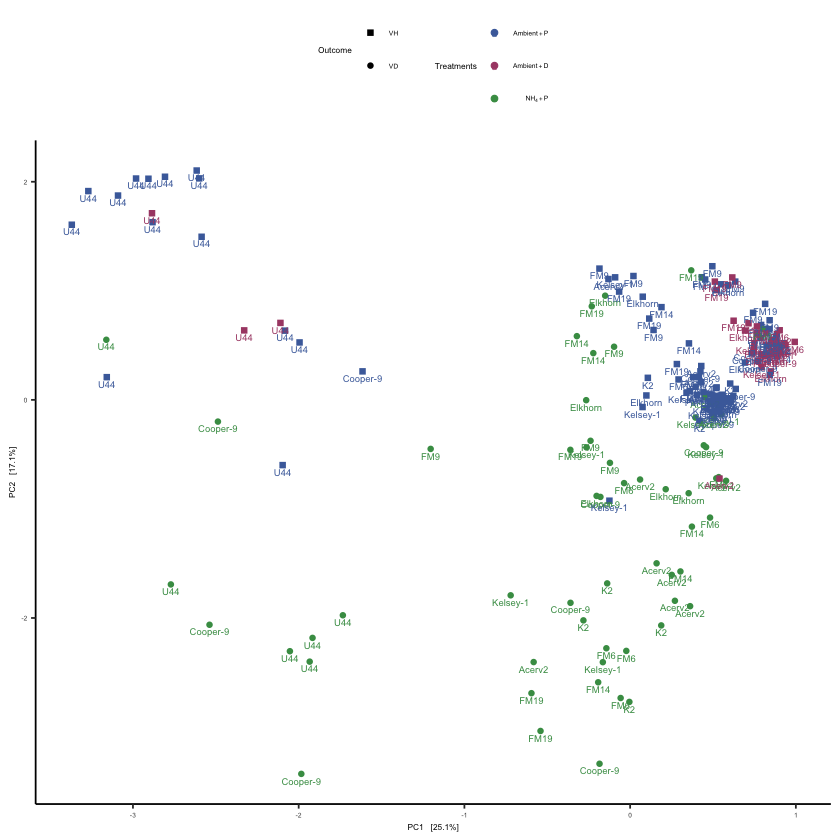

In [32]:
plot_ordination(ps_clr_clip, psr_clr.ord_clip,
                               color="Outcome",
                              shape="Health",
                               label="Genotype",
                            axes = c(1,2)) +
scale_color_manual("Treatments", values = c("#4A6CAA", "#AA4A74", "#469B53" ,"#454B1B", "#AA4A74"), labels= lab1) + 
scale_shape_manual("Outcome", values = c(15, 16), labels= lab2) +
theme_classic() +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
theme(legend.position = 'top', 
     legend.text =element_text(size=4), legend.title=element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.text.y = element_text(size =4)) +
guides(shape = guide_legend(nrow = 2, byrow = TRUE)) +
guides(col = guide_legend(nrow = 3, byrow = TRUE))
 



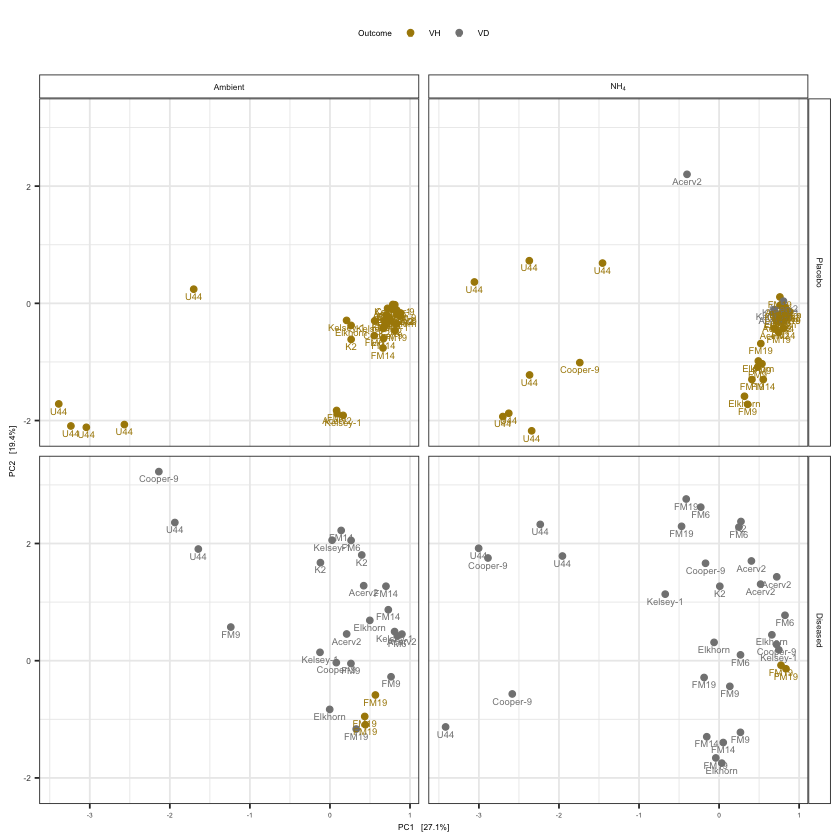

In [83]:
sample_data(ps_clr_fill_pair)$Diseased <- factor(sample_data(ps_clr_fill_pair)$Diseased, 
    levels = c("Placebo", "Pathogen"))


supp.labs <- as_labeller(c(Placebo="Placebo", Pathogen="Diseased"),
                           default = label_parsed)
my_labeller <- as_labeller(c(Ambient="Ambient", NH4="NH[4]"),
                           default = label_parsed)



ord_combo = plot_ordination(ps_clr_fill_pair, ps_clr.ord_fill_pair,
                              color="Health",
            
                               label="Genotype",
                            axes = c(1,2)) +
facet_grid(Diseased~Nutrients, space="free", labeller = labeller(Nutrients=my_labeller,
                                                                    label_parsed, Diseased= supp.labs)) +

scale_color_manual("Outcome", values = c("#AA8805", "#838383"), labels= lab2) + 

#scale_shape_manual("Outcome", values = c(15, 16), labels= lab2) +
theme_bw() +
#labs(fill='Taxon')  +
theme(strip.background = element_rect(fill="white")) +
guides(fill = guide_legend(keywidth = 0.30, , keyheight =.60, ncol=1)) +
theme(legend.position = 'top') +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.text.y = element_text(size =5)) +
theme(strip.text.x = element_text(size =5)) +
theme(strip.text.y = element_text(size =5)) 

ord_combo



In [63]:
ps_clr_meta= as(sample_data(ps_clr_fill_pair), "data.frame")

#distances between disease state
ps_clr <- vegdist(otu_table(t(ps_clr_fill_pair)), method ="euclidean")

mod <- betadisper(ps_clr, sample_data(ps_clr_fill_pair)$Combo)
#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)
mod

mod_dist= as.data.frame(mod$distances)
dim(mod_dist)
mod_dist_df=cbind(sample_data(ps_clr_fill_pair), mod_dist) 
head(mod_dist)


	Homogeneity of multivariate dispersions

Call: betadisper(d = ps_clr, group =
sample_data(ps_clr_fill_pair)$Combo)

No. of Positive Eigenvalues: 71
No. of Negative Eigenvalues: 0

Average distance to median:
Ambient_Pathogen  Ambient_Placebo     NH4_Pathogen      NH4_Placebo 
           15.84            10.13            17.93            11.09 

Eigenvalues for PCoA axes:
(Showing 8 of 71 eigenvalues)
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
9329.8 6694.3 3479.0 2376.1 1561.2 1127.1  746.6  691.4 

[1] 135   1

,mod$distances
,<dbl>
N115-247,19.902708
N211-A191,5.412030
N227-A105,29.821269
N228-A106,31.919772
N230-A162,5.229574
N233-A196,8.260780


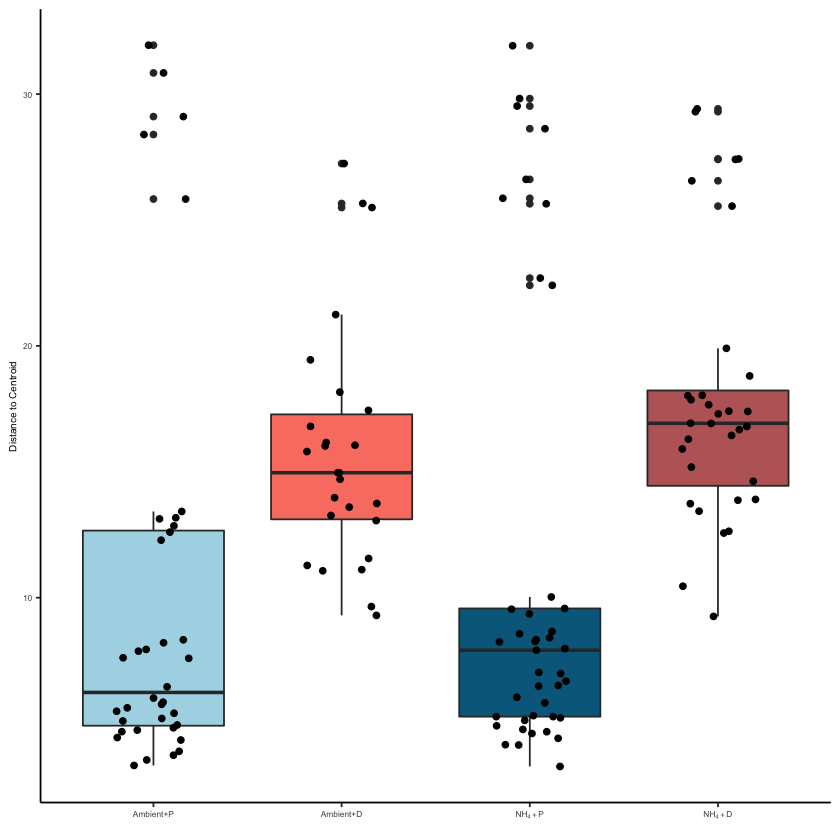

In [130]:
mod_dist_df$Combo <- factor(mod_dist_df$Combo, 
    levels = c("Ambient_Placebo", "Ambient_Pathogen", "NH4_Placebo", "NH4_Pathogen"))


combo_cent= ggplot(mod_dist_df,
       aes(x=Combo, y=mod$distances)) +
geom_boxplot(aes(fill=Combo)) +
geom_jitter(aes(fill = Combo), height = 0, width = .2) +
theme_classic() +
scale_fill_manual(values =c("lightblue", "salmon", "#00688B", "#bc6767")) +
  theme(legend.position ="none") +
ylab("Distance to Centroid") +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 4)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
scale_x_discrete(labels=c("Ambient_Pathogen" = "Ambient+D", "Ambient_Placebo" = "Ambient+P",
                              "NH4_Pathogen" = expression(paste(NH[4])+D), 
                          "NH4_Placebo" = expression(paste(NH[4])+P) )) +
xlab("")

combo_cent

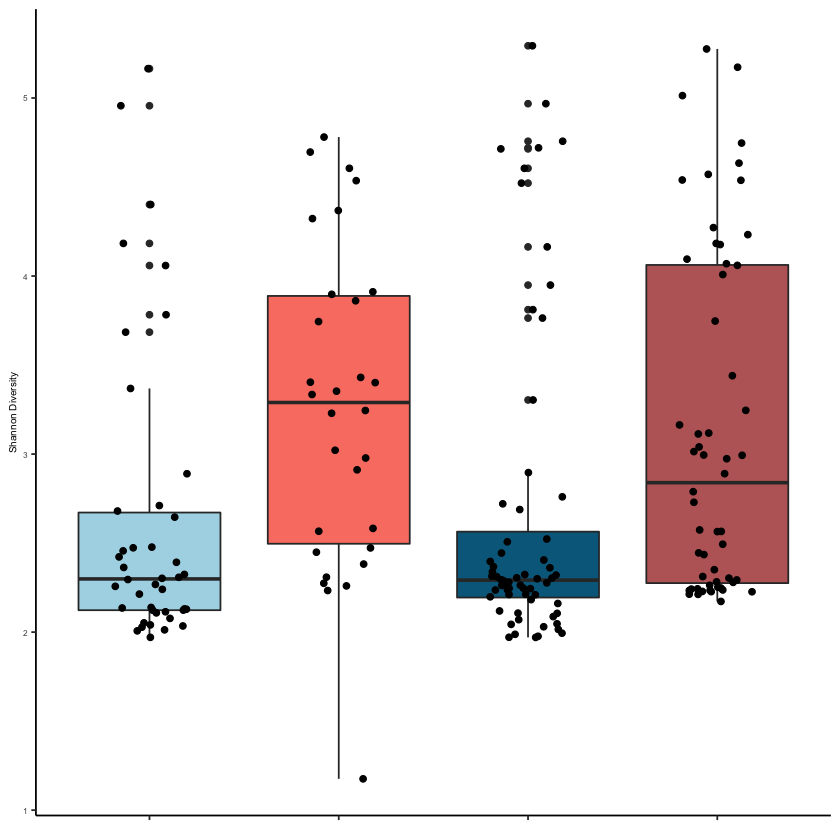

In [132]:
meta$Combo <- factor(meta$Combo, 
    levels = c("Ambient_Placebo", "Ambient_Pathogen", "NH4_Placebo", "NH4_Pathogen"))


combo_shanon= meta %>%
filter(Shannon>0) %>%
  ggplot(aes(x = Combo, y = as.numeric(Shannon))) +
geom_boxplot(aes(fill=Combo)) +
geom_jitter(aes(fill = Combo), height = 0, width = .2) +
theme_classic() +
scale_fill_manual(values =c("lightblue", "salmon", "#00688B", "#bc6767")) +
  labs(y = "Shannon Diversity", x = "") +
  theme(legend.position ="none") +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 4)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.x = element_blank()) +
theme(axis.text.y = element_text(size =5)) +
scale_x_discrete(labels=c("Ambient_Pathogen" = "Ambient+D", "Ambient_Placebo" = "Ambient+P",
                              "NH4_Pathogen" = expression(paste(NH[4])+D), 
                          "NH4_Placebo" = expression(paste(NH[4])+P) )) 


combo_shanon

In [133]:
comboAB= ggpubr::ggarrange(combo_shanon, combo_cent,
                  common.legend = FALSE, ncol=1,
                labels = c("A", "B"), font.label = list(size = 9))

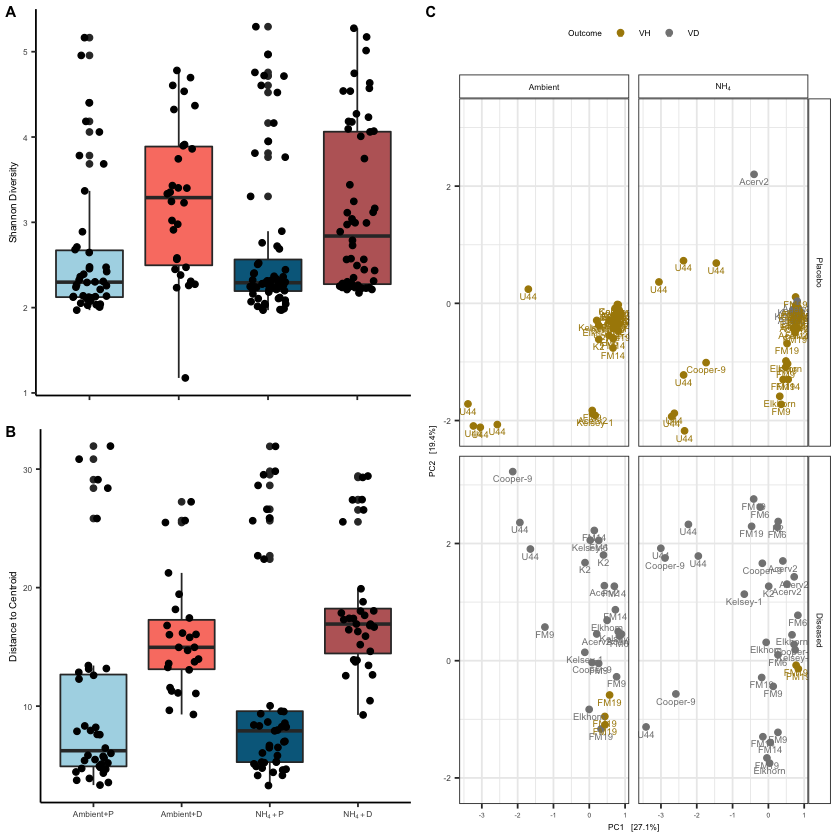

In [134]:
ggpubr::ggarrange(comboAB, ord_combo,
                  common.legend = FALSE,
                labels = c("", "C"), font.label = list(size = 9))
ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/Fig1.png", 
      width = 6, height = 5, units = "in", dpi=300)

In [12]:
sum_ps_pair   <- ps_fill_pair %>%
  #tax_glom(taxrank = "Family") %>%
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()


sum_ps_Am_Pl_c  <- ps_Am_Pl_c %>%
  #tax_glom(taxrank = "Family") %>%
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()


sum_ps_Am_Pl_r  <- ps_Am_Pl_r %>%
  #tax_glom(taxrank = "Family") %>%
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()


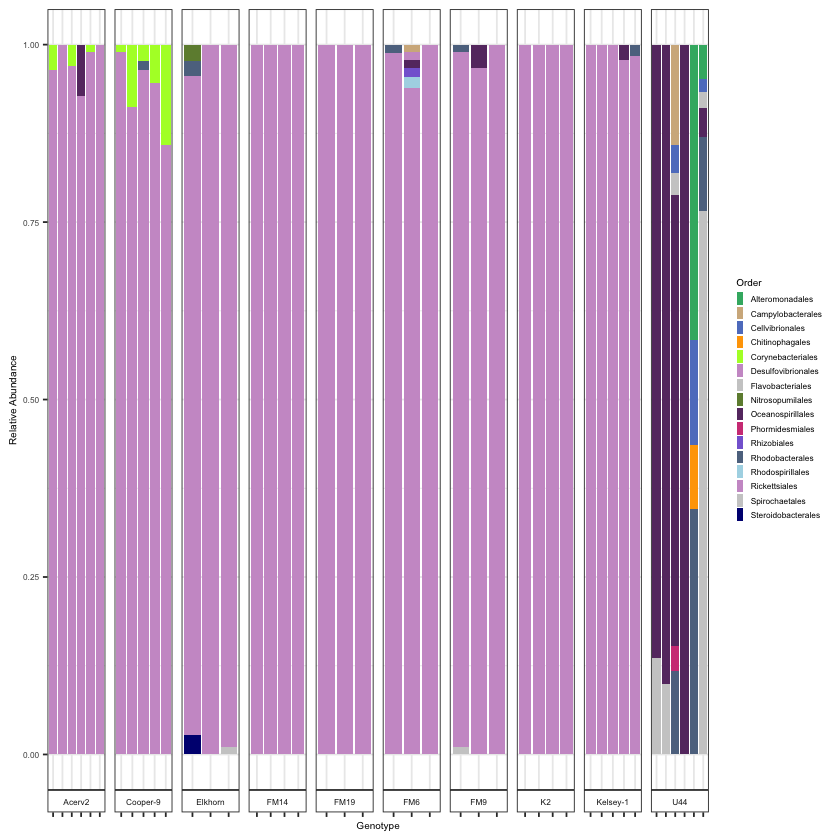

In [178]:


sum_ps_Am_Pl_c %>%
filter(Abundance >0.009) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%
ggplot(
       aes(x=sample_names, y= Abundance, fill=Order)) + 
theme_bw() +
geom_bar(stat = "identity",position="fill") +

#geom_boxplot() +
#scale_y_continuous(trans = "log10") +
#geom_point(position = position_jitterdodge(), alpha=0.5, size=1) +
facet_grid(.~Genotype, scales="free_x",  switch="both") +
scale_fill_manual(values=c("#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F",
                          "lightblue", "#CD9BCD","gray80","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724"
                           ,"#8fa746","#404b1f","#8FBC8F",
                           "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F","#AD6F3B",
                          "lightblue", "salmon","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F"
                          )) +
#geom_point(aes(size= Abundance), alpha=0.4) +
theme_bw() +
theme(legend.title = element_text(size=10)) +
#labs(fill='Taxon')  +
ylab("Relative Abundance") +
xlab("Genotype") +
guides(fill = guide_legend(keywidth = 0.30, , keyheight =.60, ncol=1)) +
theme(strip.background = element_rect(fill="white")) +
theme(axis.text.x = element_blank()) +
theme(strip.text.x = element_text(size = 5)) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.y = element_text(size =5)) 


ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/sup3.png", 
      width = 5.5, height = 4, units = "in", dpi=300)

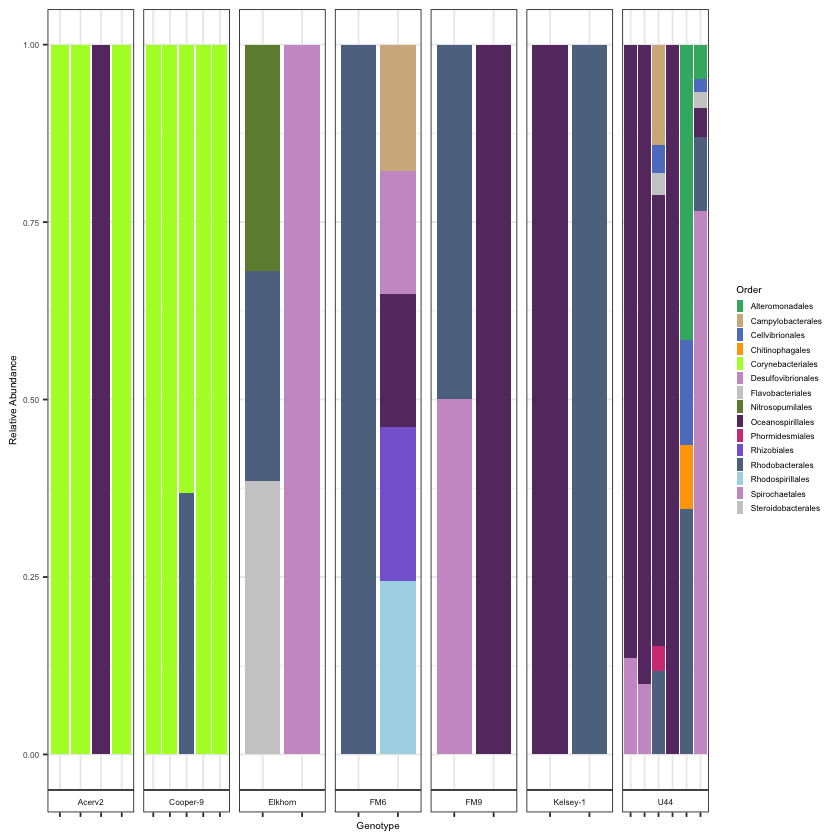

In [44]:
sum_ps_Am_Pl_c %>%
filter(Abundance >0.009) %>%
filter(Order != " o__Rickettsiales") %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%
ggplot(
       aes(x=sample_names, y= Abundance, fill=Order)) + 
theme_bw() +
geom_bar(stat = "identity",position="fill") +

#geom_boxplot() +
#scale_y_continuous(trans = "log10") +
#geom_point(position = position_jitterdodge(), alpha=0.5, size=1) +
facet_grid(.~Genotype, scales="free_x",  switch="both") +
scale_fill_manual(values=c("#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F",
                          "lightblue", "#CD9BCD","gray80","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724"
                           ,"#8fa746","#404b1f","#8FBC8F",
                           "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F","#AD6F3B",
                          "lightblue", "salmon","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F"
                          )) +
#geom_point(aes(size= Abundance), alpha=0.4) +
theme_bw() +
theme(legend.title = element_text(size=10)) +
#labs(fill='Taxon')  +
ylab("Relative Abundance") +
xlab("Genotype") +
guides(fill = guide_legend(keywidth = 0.30, , keyheight =.60, ncol=1)) +
theme(strip.background = element_rect(fill="white")) +
theme(axis.text.x = element_blank()) +
theme(strip.text.x = element_text(size = 5)) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.y = element_text(size =5))

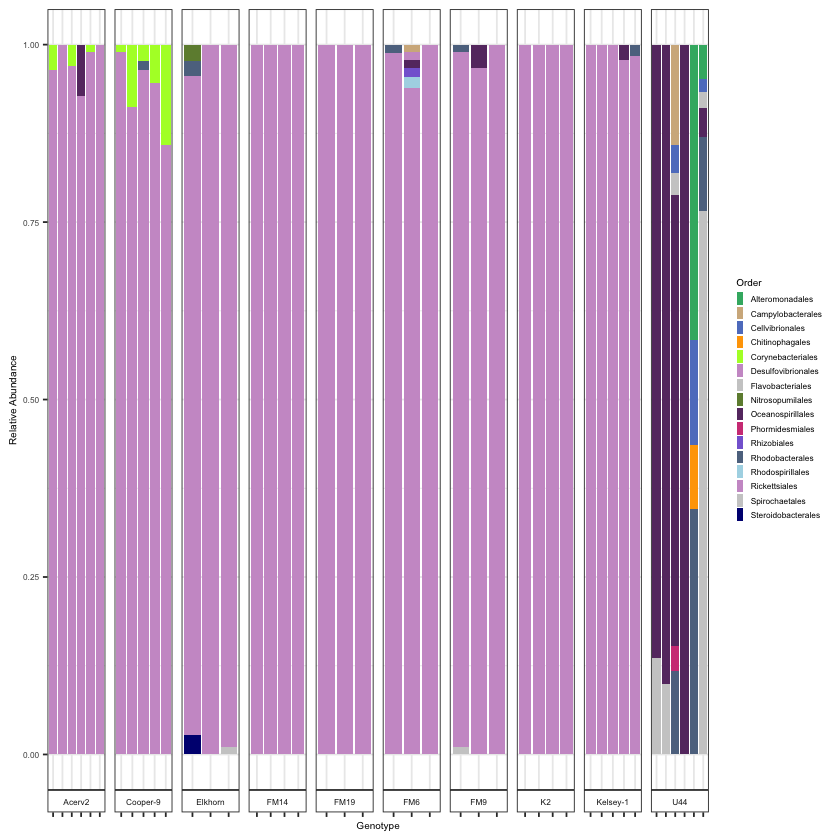

In [40]:
sum_ps_Am_Pl_c %>%
filter(Abundance >0.009) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%
ggplot(
       aes(x=sample_names, y= Abundance, fill=Order)) + 
theme_bw() +
geom_bar(stat = "identity",position="fill") +

#geom_boxplot() +
#scale_y_continuous(trans = "log10") +
#geom_point(position = position_jitterdodge(), alpha=0.5, size=1) +
facet_grid(.~Genotype, scales="free_x",  switch="both") +
scale_fill_manual(values=c("#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F",
                          "lightblue", "#CD9BCD","gray80","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724"
                           ,"#8fa746","#404b1f","#8FBC8F",
                           "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F","#AD6F3B",
                          "lightblue", "salmon","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F"
                          )) +
#geom_point(aes(size= Abundance), alpha=0.4) +
theme_bw() +
theme(legend.title = element_text(size=10)) +
#labs(fill='Taxon')  +
ylab("Relative Abundance") +
xlab("Genotype") +
guides(fill = guide_legend(keywidth = 0.30, , keyheight =.60, ncol=1)) +
theme(strip.background = element_rect(fill="white")) +
theme(axis.text.x = element_blank()) +
theme(strip.text.x = element_text(size = 5)) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.y = element_text(size =5)) 


In [13]:
sum_ps_pair   <- ps_fill_clip %>%
  #tax_glom(taxrank = "Family") %>%
  #transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()

In [14]:
sum_ps_pair_nr   <- ps_fill_clip_nr %>%
  #tax_glom(taxrank = "Family") %>%
  #transform_sample_counts(function(x) {x/sum(x)*100} ) %>% # Transform to rel. abundance
  psmelt()

In [15]:
first_hom=c("N88-Hom-H", "N88-Hom-H-R2", "N87-Hom-D", "N87-Hom-D-R2")


ps_homgenate=subset_samples(ps_pre, Type=="Homogenate"& sample_names %in% first_hom)
ps_homgenate

ps_homgenate = filter_taxa(ps_homgenate, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_homgenate 


sum_homogenate   <- ps_homgenate %>%
  #tax_glom(taxrank = "Family") %>%
  #transform_sample_counts(function(x) {x/sum(x)*100} ) %>% # Transform to rel. abundance
  psmelt()

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 4 samples ]
sample_data() Sample Data:       [ 4 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 467 taxa and 4 samples ]
sample_data() Sample Data:       [ 4 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 467 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 467 tips and 458 internal nodes ]

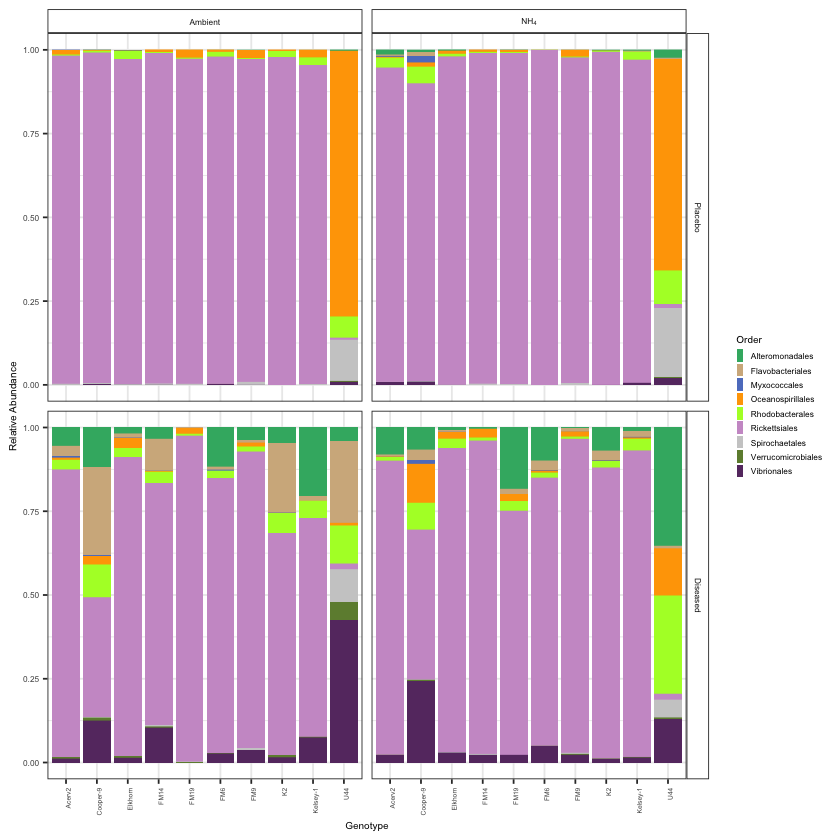

In [25]:
sum_ps_pair$Diseased <- factor(sum_ps_pair$Diseased, 
   levels = c("Placebo", "Pathogen"))


supp.labs <- as_labeller(c(Placebo="Placebo", Pathogen="Diseased"),
                           default = label_parsed)
my_labeller <- as_labeller(c(Ambient="Ambient", NH4="NH[4]"),
                           default = label_parsed)



f1 = sum_ps_pair %>%
mutate(rel_abund = (Abundance / sum(Abundance))*100) %>%
filter(Abundance >0.01) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "_",
                replacement = " ")  %>%
ggplot(
       aes(x=Genotype, y= rel_abund, fill=Order)) + 
theme_bw() +
geom_bar(stat = "identity",position="fill") +

#geom_boxplot() +
#scale_y_continuous(trans = "log10") +
#geom_point(position = position_jitterdodge(), alpha=0.5, size=1) +
scale_fill_manual(values=c("#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F",
                          "lightblue", "salmon","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724"
                           ,"#8fa746","#404b1f","#8FBC8F",
                           "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F","#AD6F3B",
                          "lightblue", "salmon","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F"
                          )) +
#geom_point(aes(size= Abundance), alpha=0.4) +
theme_bw() +
#labs(fill='Taxon')  +
ylab("Relative Abundance") +
xlab("Genotype") +
theme(strip.background = element_rect(fill="white")) +
guides(fill = guide_legend(keywidth = 0.30, , keyheight =.60, ncol=1)) +
theme(axis.text.x = element_text(angle = 90, hjust = 1)) +

theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.text.y = element_text(size =5)) +
theme(strip.text.x = element_text(size =5)) +
theme(strip.text.y = element_text(size =5)) +
facet_grid(Diseased~Nutrients) +
facet_grid(Diseased~Nutrients, scale="free", space="free", labeller = labeller(Nutrients=my_labeller,
                                                                    label_parsed, Diseased= supp.labs)) 
f1

ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/sup1.png", 
      width = 4, height = 4, units = "in", dpi=300)

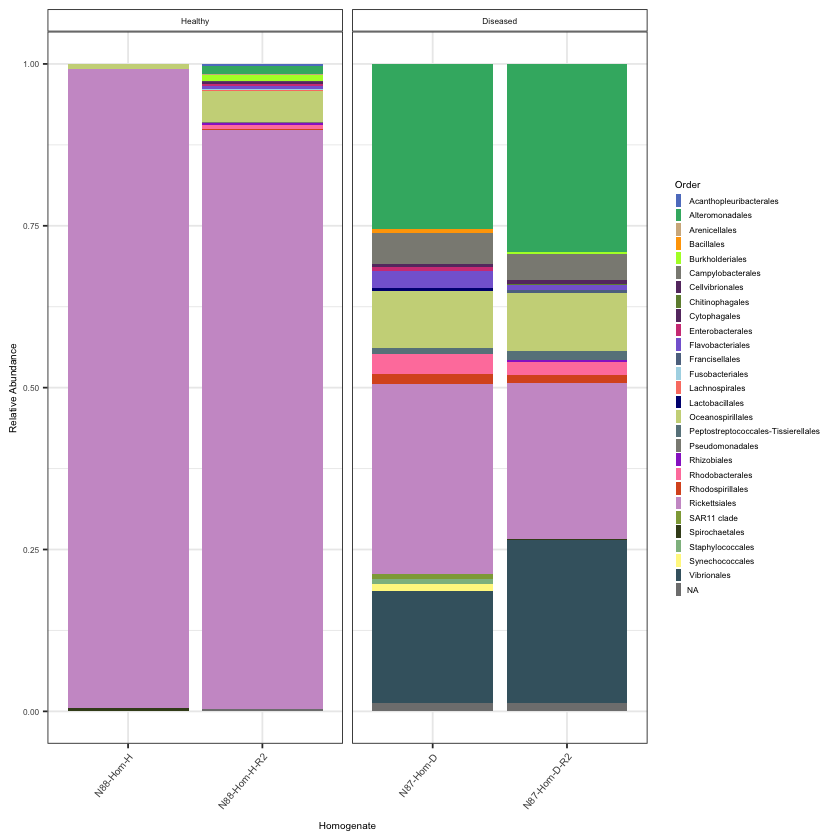

In [31]:
#sum_homogenate$Health <- factor(sum_homogenate$Health, 
 #  levels = c("DL", "AH"))


supp.labs <- c("Healthy", "Diseased")
names(supp.labs) <- c("AH","DL")

fig_supp2= sum_homogenate %>%
mutate(rel_abund = (Abundance / sum(Abundance))*100) %>%
filter(rel_abund  >0.05) %>%
#filter(sample_names!=c("N4-Hom-D")) %>%
#filter(sample_names!=c("N3-Hom-D")) %>%
#filter(sample_names!=c("N2-Hom-H")) %>%
#filter(Homogenate=!"N4-H-D") %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "_",
                replacement = " ")  %>%


ggplot(
       aes(x=sample_names, y= rel_abund, fill=Order)) + 
theme_bw() +
geom_bar(stat = "identity",position="fill") +

scale_fill_manual(values=c("#5F7FC7", "#3CB371","tan","orange","#ADFF2F", 
                           "ivory4", "#673770",  "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F",
                          "lightblue", "salmon","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724"
                           ,"#8fa746","#404b1f","#8FBC8F",
                           "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F","#AD6F3B",
                          "lightblue", "salmon","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F"
                          )) +
theme_bw() +
#labs(fill='Taxon')  +
ylab("Relative Abundance") +
xlab("Homogenate") +
theme(strip.background = element_rect(fill="white")) +
guides(fill = guide_legend(keywidth = 0.30, , keyheight =.60, ncol=1)) +
theme(axis.text.x = element_text(angle = 50, hjust = 1)) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.x = element_text(size =6)) +
theme(axis.text.y = element_text(size =5)) +
theme(strip.text.x = element_text(size =5)) +
theme(strip.text.y = element_text(size =5)) +
facet_grid(.~Health, scales="free", space="free", labeller = labeller(Health = supp.labs)) 



fig_supp2

ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/sup2.png", 
      width = 4, height = 4, units = "in", dpi=300)

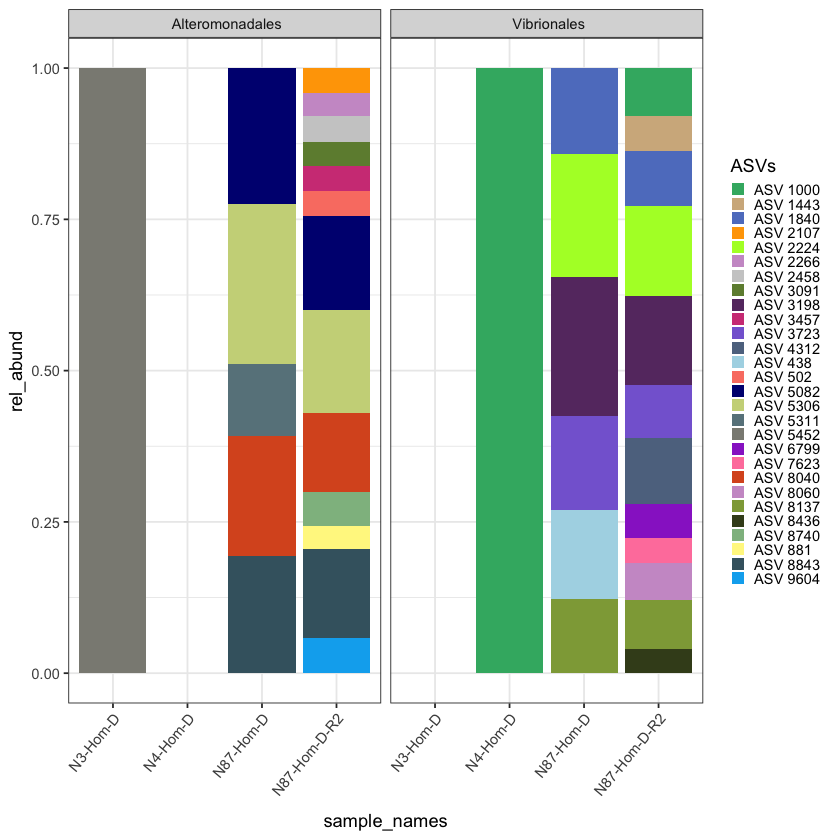

In [283]:
sum_homogenate %>%
mutate(rel_abund = (Abundance / sum(Abundance))*100) %>%
filter(rel_abund  >0.1) %>%
filter(grepl("o__Vibrionales|o__Alteromonadales", Order)) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "_",
                replacement = " ")  %>%

ggplot(
       aes(x=sample_names, y= rel_abund, fill=ASVs)) + 
theme_bw() +
geom_bar(stat = "identity",position="fill") +
facet_wrap(.~Order) +

scale_fill_manual(values=c("#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F",
                          "lightblue", "salmon","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1")) +

guides(fill = guide_legend(keywidth = 0.60, , keyheight =.60, ncol=1)) +
theme(axis.text.x = element_text(angle = 50, hjust = 1)) 

In [287]:
sum_homogenate_df =sum_homogenate %>%
mutate(rel_abund = (Abundance / sum(Abundance))*100) %>%
filter(rel_abund  >0.1) %>%
filter(grepl("o__Vibrionales|o__Alteromonadales", Order)) 

sum_homogenate_df$ASVs

[1] "ASV_5306" "ASV_5082" "ASV_8843" "ASV_2224" "ASV_3198" "ASV_8040"
 [7] "ASV_4312" "ASV_1840" "ASV_5306" "ASV_3723" "ASV_8137" "ASV_1000"
[13] "ASV_5082" "ASV_3198" "ASV_8040" "ASV_8843" "ASV_8060" "ASV_2224"
[19] "ASV_9604" "ASV_1443" "ASV_8740" "ASV_6799" "ASV_3723" "ASV_438" 
[25] "ASV_2458" "ASV_3457" "ASV_1840" "ASV_5452" "ASV_2107" "ASV_502" 
[31] "ASV_3091" "ASV_8436" "ASV_7623" "ASV_5311" "ASV_1000" "ASV_2266"
[37] "ASV_881"  "ASV_8137"

In [232]:
hom_ASVs = as.data.frame(tax_table(ps_Am_Pa_c_fill)) %>%
rownames_to_column("taxon") %>%
inner_join(as.data.frame(tax_table(ps_homgenate), "ASVs")) %>%
column_to_rownames("taxon") %>%
as.matrix


ps_home_disase= phyloseq(otu_table(ASVs, taxa_are_rows=TRUE), 
               sample_data(meta),
              tax_table(hom_ASVs))
ps_home_disase
ps_Am_Pa_c_fill

Joining, by = c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species", "ASVs")


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 98 taxa and 280 samples ]
sample_data() Sample Data:       [ 280 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 98 taxa by 8 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2017 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 2017 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2017 tips and 1837 internal nodes ]

In [222]:
library(microbiome)

In [244]:
 core_members(ps_Am_Pa_c_fill, detection = 0, prevalence = 50/100)

[1] "58a75ecc587c36de8b4bbbac0c6efff2" "7faad2d299566d181c7c321533a13692"
 [3] "c26b47e8b0fd4b379a2e0772b3fb75fd" "af9929b8c403fc72989769d9876fc007"
 [5] "ff3e7637bd5aac86cff3b72f9ee78f47" "1788860a6d5db952c73537bc4f00e6ec"
 [7] "57cae3e69e447f81b06a7ab5275a3ea8" "c429cce2851f42f0d5a5f2b50fe18e33"
 [9] "615834b295798beef85aedd0dccb7cdf" "1f388d6a52fb1fe4e6010cd40d4cbda6"
[11] "f242850c598d509ac98aea5999f2779f" "3790ac5be14bbbdc8719ce6632dcb64b"
[13] "4f2ea9eaa10dba689515577673a441eb"

In [240]:
ps_Am_Pa_c_fill
core_disea

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2017 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 2017 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 2017 tips and 1837 internal nodes ]

[1] "af9929b8c403fc72989769d9876fc007" "ff3e7637bd5aac86cff3b72f9ee78f47"
[3] "1788860a6d5db952c73537bc4f00e6ec" "57cae3e69e447f81b06a7ab5275a3ea8"
[5] "c429cce2851f42f0d5a5f2b50fe18e33" "615834b295798beef85aedd0dccb7cdf"
[7] "1f388d6a52fb1fe4e6010cd40d4cbda6"

In [245]:
core_disea=c('58a75ecc587c36de8b4bbbac0c6efff2','7faad2d299566d181c7c321533a13692','c26b47e8b0fd4b379a2e0772b3fb75fd',
             'af9929b8c403fc72989769d9876fc007','ff3e7637bd5aac86cff3b72f9ee78f47','1788860a6d5db952c73537bc4f00e6ec',
             '57cae3e69e447f81b06a7ab5275a3ea8','c429cce2851f42f0d5a5f2b50fe18e33','615834b295798beef85aedd0dccb7cdf',
             '1f388d6a52fb1fe4e6010cd40d4cbda6',
             'f242850c598d509ac98aea5999f2779f','3790ac5be14bbbdc8719ce6632dcb64b','4f2ea9eaa10dba689515577673a441eb')

allTaxa = taxa_names(ps_Am_Pa_c_fill)
allTaxa <- allTaxa[(allTaxa %in% core_disea)]
ps_core = prune_taxa(allTaxa, ps_Am_Pa_c_fill)
ps_core

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13 taxa and 30 samples ]
sample_data() Sample Data:       [ 30 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 13 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 13 tips and 10 internal nodes ]

In [249]:
sum_ps_core  <- ps_core %>%
  #tax_glom(taxrank = "Family") %>%
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()

sum_home_disase = ps_home_disase %>%
  #tax_glom(taxrank = "Family") %>%
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()

In [247]:
tax_table(ps_core)

,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
58a75ecc587c36de8b4bbbac0c6efff2,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,g__Shimia,NA,ASV_3570
7faad2d299566d181c7c321533a13692,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Crocinitomicaceae,g__Fluviicola,NA,ASV_5096
c26b47e8b0fd4b379a2e0772b3fb75fd,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Crocinitomicaceae,g__Fluviicola,NA,ASV_7693
af9929b8c403fc72989769d9876fc007,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_6931
ff3e7637bd5aac86cff3b72f9ee78f47,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_10105
1788860a6d5db952c73537bc4f00e6ec,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_951
57cae3e69e447f81b06a7ab5275a3ea8,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_3537
c429cce2851f42f0d5a5f2b50fe18e33,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_7769
615834b295798beef85aedd0dccb7cdf,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_3874
1f388d6a52fb1fe4e6010cd40d4cbda6,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_1233


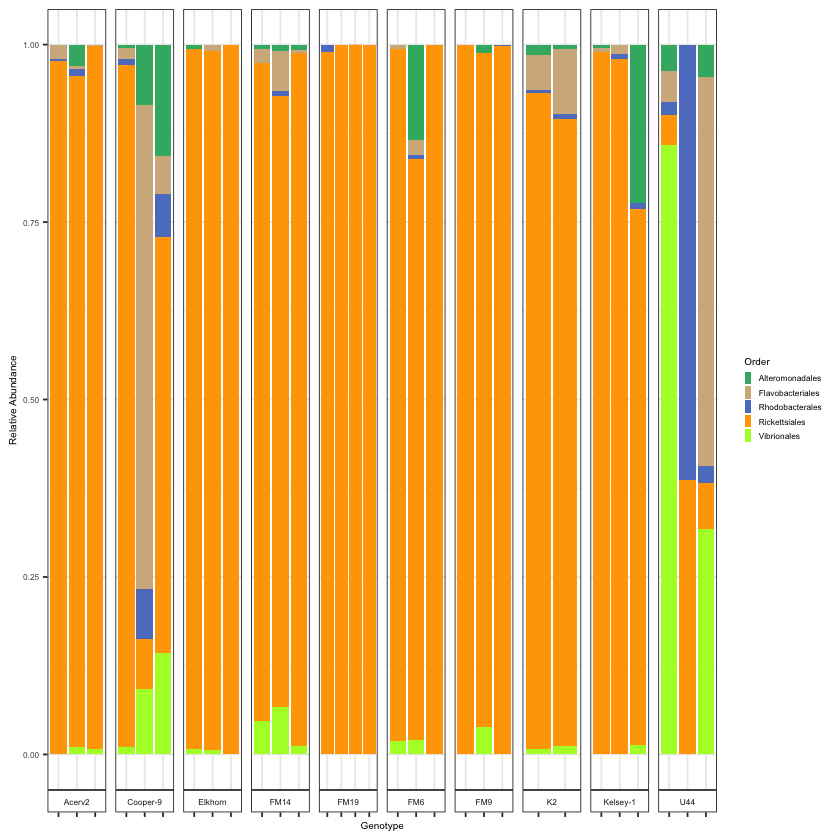

In [253]:
sum_ps_core %>%
#filter(Abundance >0.009) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%
ggplot(
       aes(x=sample_names, y= Abundance, fill=Order)) + 
theme_bw() +
geom_bar(stat = "identity",position="fill") +

#geom_boxplot() +
#scale_y_continuous(trans = "log10") +
#geom_point(position = position_jitterdodge(), alpha=0.5, size=1) +
facet_grid(.~Genotype, scales="free_x",  switch="both") +
scale_fill_manual(values=c("#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F",
                          "lightblue", "#CD9BCD","gray80","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724"
                           ,"#8fa746","#404b1f","#8FBC8F",
                           "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F","#AD6F3B",
                          "lightblue", "salmon","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F"
                          )) +
#geom_point(aes(size= Abundance), alpha=0.4) +
theme_bw() +
theme(legend.title = element_text(size=10)) +
#labs(fill='Taxon')  +
ylab("Relative Abundance") +
xlab("Genotype") +
guides(fill = guide_legend(keywidth = 0.30, , keyheight =.60, ncol=1)) +
theme(strip.background = element_rect(fill="white")) +
theme(axis.text.x = element_blank()) +
theme(strip.text.x = element_text(size = 5)) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.y = element_text(size =5)) 

ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/core.png", 
      width = 5, height = 4, units = "in", dpi=300)

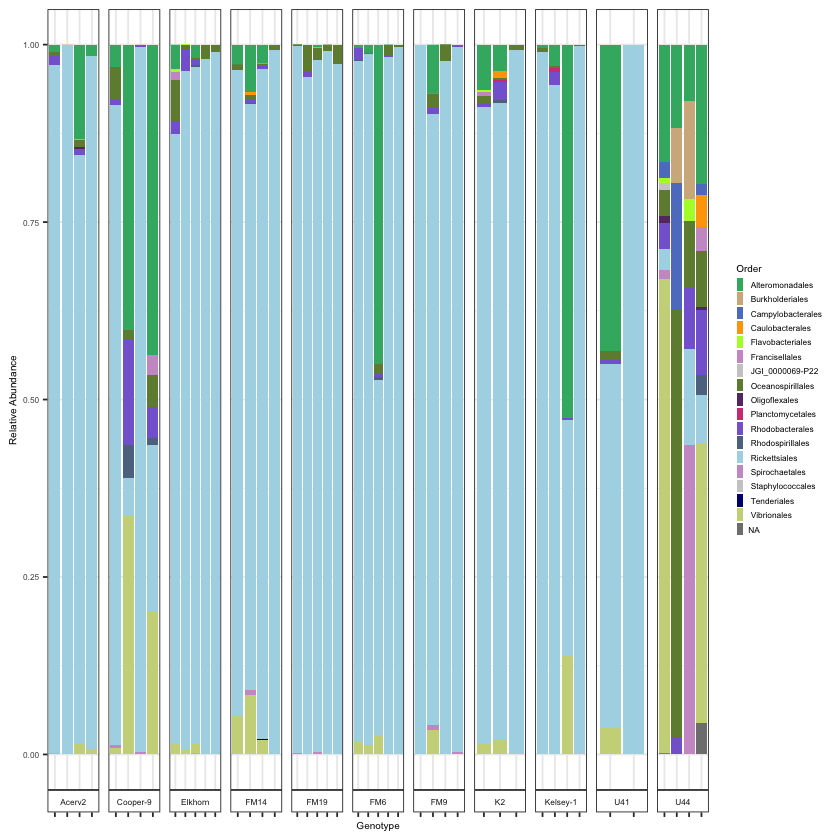

In [252]:
sum_home_disase %>%
filter(Combo=="Ambient_Pathogen") %>%
#filter(Abundance >0.009) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%
ggplot(
       aes(x=sample_names, y= Abundance, fill=Order)) + 
theme_bw() +
geom_bar(stat = "identity",position="fill") +

#geom_boxplot() +
#scale_y_continuous(trans = "log10") +
#geom_point(position = position_jitterdodge(), alpha=0.5, size=1) +
facet_grid(.~Genotype, scales="free_x",  switch="both") +
scale_fill_manual(values=c("#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F",
                          "lightblue", "#CD9BCD","gray80","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724"
                           ,"#8fa746","#404b1f","#8FBC8F",
                           "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F","#AD6F3B",
                          "lightblue", "salmon","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F"
                          )) +
#geom_point(aes(size= Abundance), alpha=0.4) +
theme_bw() +
theme(legend.title = element_text(size=10)) +
#labs(fill='Taxon')  +
ylab("Relative Abundance") +
xlab("Genotype") +
guides(fill = guide_legend(keywidth = 0.30, , keyheight =.60, ncol=1)) +
theme(strip.background = element_rect(fill="white")) +
theme(axis.text.x = element_blank()) +
theme(strip.text.x = element_text(size = 5)) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.y = element_text(size =5)) 

ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/notcore.png", 
      width = 5, height = 4, units = "in", dpi=300)

In [26]:
library(data.table)
#run function to summarize relative abundance 
fast_melt = function(physeq){
  # supports "naked" otu_table as `physeq` input.
  otutab = as(otu_table(physeq), "matrix")
  if(!taxa_are_rows(physeq)){otutab <- t(otutab)}
  otudt = data.table(otutab, keep.rownames = TRUE)
  setnames(otudt, "rn", "taxaID")
  # Enforce character taxaID key
  otudt[, taxaIDchar := as.character(taxaID)]
  otudt[, taxaID := NULL]
  setnames(otudt, "taxaIDchar", "taxaID")
  # Melt count table
  mdt = melt.data.table(otudt, 
                        id.vars = "taxaID",
                        variable.name = "SampleID",
                        value.name = "count")
  # Remove zeroes, NAs
  mdt <- mdt[count > 0][!is.na(count)]
  # Calculate relative abundance
  mdt[, RelativeAbundance := count / sum(count), by = SampleID]
  if(!is.null(tax_table(physeq, errorIfNULL = FALSE))){
    # If there is a tax_table, join with it. Otherwise, skip this join.
    taxdt = data.table(as(tax_table(physeq, errorIfNULL = TRUE), "matrix"), keep.rownames = TRUE)
    setnames(taxdt, "rn", "taxaID")
    # Enforce character taxaID key
    taxdt[, taxaIDchar := as.character(taxaID)]
    taxdt[, taxaID := NULL]
    setnames(taxdt, "taxaIDchar", "taxaID")
    # Join with tax table
    setkey(taxdt, "taxaID")
    setkey(mdt, "taxaID")
    mdt <- taxdt[mdt]
  }
  return(mdt)
}

summarize_taxa = function(physeq, Rank, GroupBy = NULL){
  Rank <- Rank[1]
  if(!Rank %in% rank_names(physeq)){
    message("The argument to `Rank` was:\n", Rank,
            "\nBut it was not found among taxonomic ranks:\n",
            paste0(rank_names(physeq), collapse = ", "), "\n",
            "Please check the list shown above and try again.")
  }
  if(!is.null(GroupBy)){
    GroupBy <- GroupBy[1]
    if(!GroupBy %in% sample_variables(physeq)){
      message("The argument to `GroupBy` was:\n", GroupBy,
              "\nBut it was not found among sample variables:\n",
              paste0(sample_variables(physeq), collapse = ", "), "\n",
              "Please check the list shown above and try again.")
    }
  }
  # Start with fast melt
  mdt = fast_melt(physeq)
  if(!is.null(GroupBy)){
    # Add the variable indicated in `GroupBy`, if provided.
    sdt = data.table(SampleID = sample_names(physeq),
                     var1 = get_variable(physeq, GroupBy))
    setnames(sdt, "var1", GroupBy)
    # Join
    setkey(sdt, SampleID)
    setkey(mdt, SampleID)
    mdt <- sdt[mdt]
  }
  # Summarize
Nsamples = nsamples(physeq)
  summarydt = mdt[, list(meanRA = (sum(RelativeAbundance)/Nsamples)*100,
                         sdRA = sd(RelativeAbundance)*100,
                         minRA = min(RelativeAbundance)*100,
                         maxRA = max(RelativeAbundance)*100),
                  by = c(Rank, GroupBy)]
  return(summarydt)
}


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [209]:
#Get mean RA
summarize_taxa(ps, GroupBy="Genotype", Rank="Class") %>%
arrange(-meanRA) #%>%
#filter(Genotype=="U44")

Class,Genotype,meanRA,sdRA,minRA,maxRA
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
c__Alphaproteobacteria,FM14,9.7721788,6.0450127,0.005934366,17.895594
c__Alphaproteobacteria,Acerv2,9.6518723,5.8618539,0.005223569,17.983669
c__Alphaproteobacteria,FM19,9.0323487,5.9053625,0.005547850,17.710033
c__Alphaproteobacteria,FM9,8.9392747,6.0194458,0.005371002,30.923077
c__Alphaproteobacteria,Kelsey-1,8.7142139,5.2282560,0.004726233,18.029475
c__Alphaproteobacteria,FM6,8.2542015,6.0529849,0.004913763,18.423909
c__Alphaproteobacteria,K2,8.1445172,5.6239467,0.004917992,17.827203
c__Alphaproteobacteria,Elkhorn,8.1209420,5.7780791,0.005456133,18.324368
c__Alphaproteobacteria,Cooper-9,5.7176616,4.1803019,0.004101134,17.654007


In [35]:
colnames(sum_homogenate)

[1] "OTU"                        "Sample"                    
 [3] "Abundance"                  "sample_names"              
 [5] "featurecounts"              "Initial_sample_ID"         
 [7] "Tag"                        "Date_Collected"            
 [9] "Date"                       "TimePoint"                 
[11] "Replicate"                  "Genotype"                  
[13] "Nursery"                    "Nutrients"                 
[15] "Diseased"                   "Combo"                     
[17] "Tank_N"                     "Tank_D1"                   
[19] "Tank_D2"                    "Type"                      
[21] "Health"                     "Outcome"                   
[23] "Notes"                      "Severity"                  
[25] "Pairs"                      "Combo_health"              
[27] "Archive_box"                "Genotype.1"                
[29] "NH4_Susceptibility"         "Disease_Susceptibility"    
[31] "NH4_Disease_Susceptibility" "Expected"                  
[33] "Surv_disease"               "Surv_nutrients"            
[35] "surv"                       "std.err"                   
[37] "barcode_label"              "barcode_seq"               
[39] "ID"                         "Sequencing_Round"          
[41] "Plate_Name"                 "Plate_Barcode"             
[43] "Well_Position"              "Sequence_Name"             
[45] "Illumina5_Adapter"          "Forward_Primer_Pad"        
[47] "Golay_Barcode"              "X515FB_Forward_Primer"     
[49] "Primer_For_PCR"             "X"                         
[51] "estimate"                   "error"                     
[53] "lower"                      "upper"                     
[55] "name"                       "model"                     
[57] "Simpson"                    "Shannon"                   
[59] "Kingdom"                    "Phylum"                    
[61] "Class"                      "Order"                     
[63] "Family"                     "Genus"                     
[65] "Species"                    "ASVs"

In [38]:
summarize_taxa(ps_homgenate, GroupBy="Health", Rank="Order") %>%
arrange(-meanRA)

Order,Health,meanRA,sdRA,minRA,maxRA
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
o__Rickettsiales,AH,45.6378772,4.85386223,0.010809642,14.2760219
o__Alteromonadales,DL,13.2908357,0.74626682,0.036799049,3.3175758
o__Rickettsiales,DL,12.2884426,0.79782497,0.038191626,3.9671552
o__Vibrionales,DL,9.8638888,0.70158009,0.038191626,2.8193733
o__Oceanospirillales,DL,4.3211784,0.23252038,0.116058539,0.9452428
o__Campylobacterales,DL,2.1686245,0.38817822,0.101905058,1.3367069
o__Oceanospirillales,AH,1.3779235,0.23326671,0.032428927,0.7745802
o__Rhodobacterales,DL,1.1813216,0.35699990,0.110397147,1.2985153
o__Flavobacteriales,DL,1.0795700,0.30235550,0.023869767,1.1791665
